# VIDUS and Lung Cancer in Never Smokers FOU GWAS
__Author:__ Jesse Marks

This document logs the steps taken to perform a GWAS on merged UHS2 and UHS3 data using the Frequency of Use (FOA) phenotype.

## Software and tools
The software and tools used for processing these data are

* RTI computing cluster (AWS)
* GNU bash version 4.1.2
* PLINK v1.9 beta 3.45
* EIGENSOFT v4.2
* R v3.2.3
* R packages: MASS, moments
* RVtests

## Pertinent information
__FOU Variables__:

`Useropioid6mfq` <br>
Combined heroin and prescription use varirable to generate opioid use in past 6 months.

`Female (sex)` <br>
0 is no, 1 is yes

`Ageatint` <br>
Age at time of interview.

__Note__: remove any individual with any of these data missing.

## Retrieve FOU data
The data have already been filtered to 
* Remove subjects with Useropioid6mfq == 0
* Remove duplicate subjects by keeping only the more recent data record
* Remove subjects with previously reported sex discrepancy

These data are located on EC2 at `/shared/sandbox/ngc_vidus-lung_cancer_fou/phenotype/GWAS-Cohort-n938_passed_g_qc_only_opioid_FOU.csv`

There are 300 subjects in this FOU file. I created a new FAM file in the genotype directory which renamed the subject IDs so that we would be able to map the phenotype data to this.

I need to filter the original `.fam` file based off of the IDs in the FOU phenotype data.


In [ ]:
cd /shared/sandbox/ngc_vidus-lung_cancer_fou/phenotype
# R console on EC2 #
pheno <- read.table("GWAS-Cohort-n938_passed_g_qc_only_opioid_FOU.csv", header=T, sep=',')

pheno_size <- length(pheno[,1])
id_list <- c()

for (i in 1:pheno_size){
    tmp_num <- sprintf("%04d", pheno[i,1]) 
    id_list <- append(id_list, tmp_num)
}

write(id_list, "id_list.txt", sep="\n")
quit()

# command line #
# filter the fam file based on the subjects that are in the FOU phenotype data
grep -f id_list.txt ../genotype/original/final/ea_chr_all.fam > filtered.fam
awk '{print $1,$1 }' filtered.fam > ea_subject_ids.keep


# get covariates
awk 'BEGIN{FS=","; OFS="\t"} {print $1,$2,$16,$17}' GWAS-Cohort-n938_passed_g_qc_only_opioid_FOU.csv > ea_FOU.data
"""
gwas_code       female  useropioid6mfq  ageatint
2       0       1       59
3       0       4       55
5       0       9       40
6       1       5       35
11      1       5       56
13      0       7       35
15      0       2       66
17      0       4       34
18      0       5       39
"""

# make sure there are no missing data for sex, FOU, or age
# Note that the phenotype data were already filtered. If they
# had not been, we would check for this. I did a visual inspection for 
# a sanity check though.

## Phenotype visualization

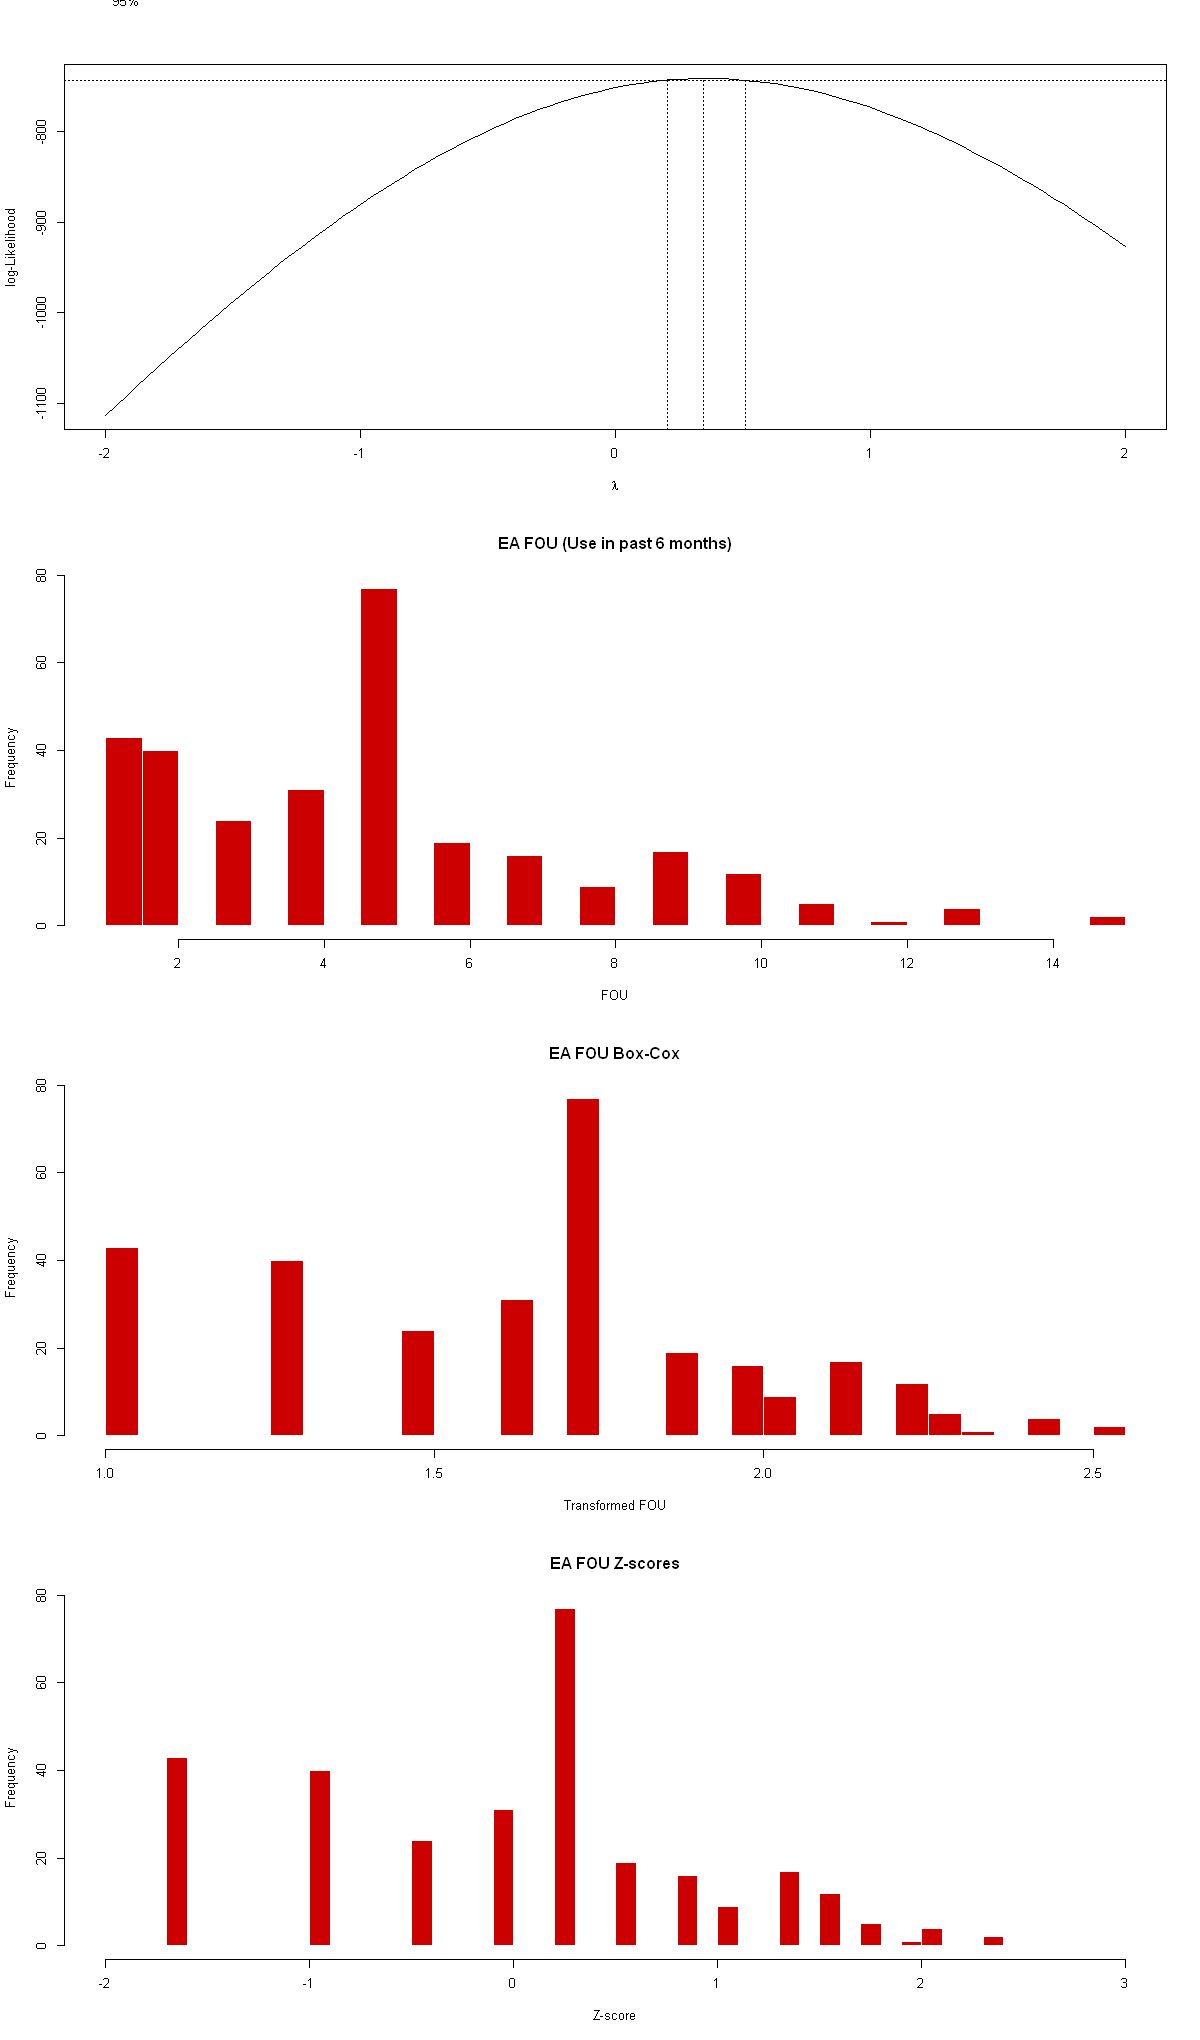

In [15]:
library(MASS)
options(repr.plot.width=10, repr.plot.height=17)
# note that I copied over the phenotype data to my local machine to produce the plots
setwd('C:/Users/jmarks/Desktop/VIDUS/pheno/phenotype/')

ea.fou.data <- read.table("ea_fou.data", header = T)
#ea.fou.data
par(mfrow=c(4,1))
# Perform boxcox transform
#ea.boxcox <- boxcox(totopioid_tot_30d+1 ~ age + sex_selfreport, data=ea.fou.data)
ea.boxcox <- boxcox(useropioid6mfq ~ ageatint + female, data=ea.fou.data)
ea.lambda <- ea.boxcox$x[which(ea.boxcox$y==max(ea.boxcox$y))]

# Convert to Z-scores
ea.zscore <- scale((ea.fou.data$useropioid6mfq)^ea.lambda, center=T, scale=T)

hist(ea.fou.data$useropioid6mfq, breaks=30, col="red3", border="white", main="EA FOU (Use in past 6 months)", xlab="FOU")

hist((ea.fou.data$useropioid6mfq)^ea.lambda, breaks=30, col="red3", border="white", main="EA FOU Box-Cox", xlab="Transformed FOU")
#
hist(ea.zscore, breaks=30, col="red3", border="white", main="EA FOU Z-scores", xlab="Z-score", xlim=c(-2,3))


  0   1 
210  90 

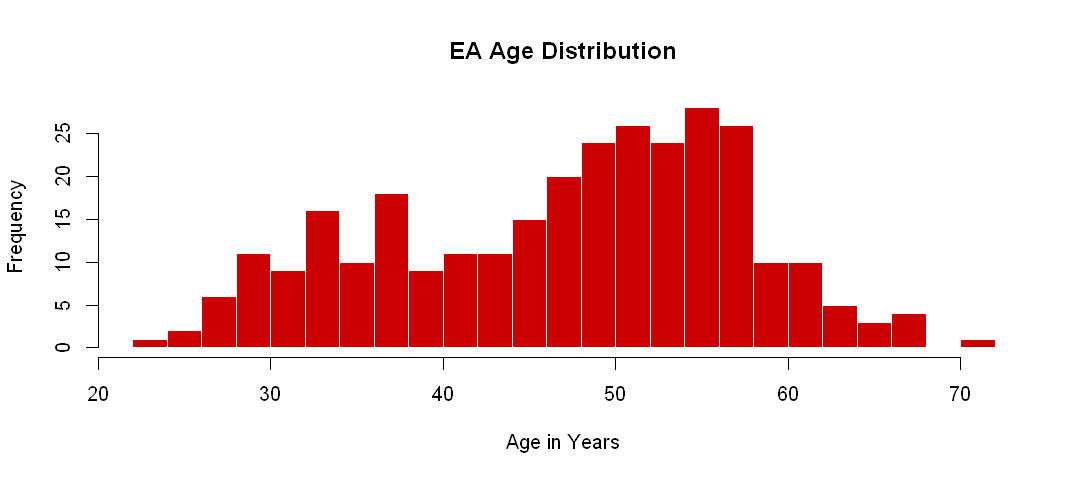

In [22]:
options(repr.plot.width=9, repr.plot.height=4)

# Plot age
hist(ea.fou.data$ageatint, breaks=30, col="red3", border="white", main="EA Age Distribution", xlab="Age in Years")

# Plot sex
table(ea.fou.data$female)
#ea.zscore

## EIGENSTRAT
To obtain principal component covariates to use in the GWAS statistical model, EIGENSTRAT is run on LD-pruned observed genotypes for each ancestry group. Usually a GRCh37 plus strand check is implemented, as well as a monomorphic SNP filter and discordant allele flip. Since this was already done for data in preparation for haplotype phasing, the haplotype phasing input PLINK files will be used. Note: In addition to these aforementioned data processing steps, ambiguous SNPs identified by reference panel frequency differences in the discordant allele checks were also removed prior to phasing.

### Construct subject-filtered PLINK file sets

In [ ]:
# Command line #
mkdir -p /shared/sandbox/ngc_vidus-fou/eigenstrat
cd /shared/sandbox/ngc_vidus-fou/eigenstrat

# Remove subjects by phenotype criteria
ancestry="ea"
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ../genotype/original/final/ea_chr_all \
    --keep ../phenotype/ea_subject_ids.keep \
    --make-bed \
    --out ${ancestry}_pheno_filter

### Remove high-LD region variants

In [ ]:
# Command line # 
cd /shared/sandbox/ngc_vidus-fou/eigenstrat

# Remove high-LD region variants
ancestry="ea"
# Generate list of variants in known high-LD regions
perl -lane 'if (($F[0]==5 && $F[3] >= 43964243 && $F[3] <= 51464243) || ($F[0]==6 && $F[3] >= 24892021 && $F[3] <= 33392022) || ($F[0]==8 && $F[3] >= 7962590 && $F[3] <= 11962591) || ($F[0]==11 && $F[3] >= 45043424 && $F[3] <= 57243424)) { print $F[1]."\n"; }' ${ancestry}_pheno_filter.bim \
    > ${ancestry}.high_ld_regions.remove

# Remove SNPs in known high-LD regions
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --bfile ${ancestry}_pheno_filter \
    --exclude ${ancestry}.high_ld_regions.remove \
    --make-bed \
    --out ${ancestry}_high_ld_regions_removed

## Linkage disequilibrium pruning
Linkage disequilibrium (LD) pruning eliminates a large degree of redundancy in the data and reduces the influence of chromosomal artifacts. The objective of LD pruning is to select a subset of variants based off of LD such that the variants in the subset are indepdendent. This filtering will not carry forward to the final processed results, but this step improves the quality of EIGENSTRAT calculations. Consequently, the LD pruned data will be used as input for those calculations.

LD pruning is implemented using PLINK `--indep-pairwise.`

In [ ]:
# Command line # 
cd /shared/sandbox/ngc_vidus-fou/eigenstrat

# Remove high-LD region variants
ancestry="ea"
# Run per chromosome LD pruning for each chr
for chr in {1..23}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr}_ld_prune \
        --script_prefix ${ancestry}_${chr}_ld_prune \
        --mem 3.5 \
        --nslots 1 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
            --noweb \
            --memory 3500 \
            --bfile ${ancestry}_high_ld_regions_removed \
            --indep-pairwise 1500 150 0.2 \
            --chr ${chr} \
            --out ${ancestry}_chr${chr}_ld_pruned
done

#Create LD pruned PLINK file sets
ancestry="ea"
# Merge *prune.in files
cat ${ancestry}_chr*_ld_pruned.prune.in > ${ancestry}_chr_all_ld_pruned.prune.in

# Create new PLINK filesets with only lD pruned variants
/shared/bioinformatics/software/third_party/plink-1.90-beta-4.10-x86_64/plink \
    --noweb \
    --memory 2048 \
    --bfile ${ancestry}_high_ld_regions_removed \
    --extract ${ancestry}_chr_all_ld_pruned.prune.in \
    --make-bed \
    --out ${ancestry}_ld_pruned


# Clean up
rm *ld_pruned.{prune.in,prune.out,log}
rm *qsub*
rm *high_ld_regions*

## Rename BIM/FAM file IDs
BIM and FAM file IDs have the potential issue of being too long if encoded using the 1000 Genomes Phase 3 IMPUTE2 format. This will cause `smartpca` to throw an error. To resolve this the IDs are replaced by numeric values if needed.

In [ ]:
# Command line # 
cd /shared/sandbox/ngc_vidus-fou/eigenstrat

# Count ID lengths greater than 39 characters
ancestry="ea"
echo -e "\n\n======== ${ancestry} ========\n\n"
awk '{ if(length($1)+length($2)>39){print $2} }' ${ancestry}_ld_pruned.fam | wc -l
awk '{ if(length($2)>39){print $2} }' ${ancestry}_ld_pruned.bim | wc -l

# Rename BIM file IDs
# Make new BIM
awk '{$2="ID_"NR; print $0}' ${ancestry}_ld_pruned.bim \
    > ${ancestry}_ld_pruned_id_renamed.bim

# Rename FAM file IDs
# Make new FAM
awk '{$1="ID_"NR; print $0}' ${ancestry}_ld_pruned.fam \
    > ${ancestry}_ld_pruned_id_renamed.fam

### Run EIGENSTRAT
__NOTE__: For `smartpca` to run, the BIM and FAM file IDs need to be less than 39 characters in length. Often this is not a problem, but with a BIM file that has IDs renamed to the 1000 Genomes Phase 3 format, the IDs for indels can exceed the character limit. Also, the EIGENSOFT bin directory should be in ~/.bashrc as an addition to the PATH variable. If it is not, it can be added as following

`export PATH=$PATH:/shared/bioinformatics/software/third_party/EIG-6.1.4/bin/` # Add EIGENSOFT bin to path

The `smartpca.pl` program documentation is shown below:


DOCUMENTATION of `smartpca.pl` program:

This program calls the `smartpca` program (see ../POPGEN/README). 
For this to work, the bin directory containing `smartpca` MUST be in your path. 
See `./example.perl` for a toy example.
```
../bin/smartpca.pl 
-i example.geno  : genotype file in any format (see ../CONVERTF/README)
-a example.snp   : snp file in any format (see ../CONVERTF/README)
-b example.ind   : indiv file in any format (see ../CONVERTF/README)
-k k             : (Default is 10) number of principal components to output
-o example.pca   : output file of principal components.  Individuals removed
                   as outliers will have all values set to 0.0 in this file.
-p example.plot  : prefix of output plot files of top 2 principal components.
                   (labeling individuals according to labels in indiv file)
-e example.eval  : output file of all eigenvalues
-l example.log   : output logfile
-m maxiter       : (Default is 5) maximum number of outlier removal iterations.
                   To turn off outlier removal, set -m 0.
-t topk          : (Default is 10) number of principal components along which 
                   to remove outliers during each outlier removal iteration.
-s sigma         : (Default is 6.0) number of standard deviations which an
                   individual must exceed, along one of topk top principal
           components, in order to be removed as an outlier.

OPTIONAL FLAGS:
-w poplist       : compute eigenvectors using populations in poplist only,
                   where poplist is an ASCII file with one population per line
-y plotlist      : output plot will include populations in plotlist only, 
                   where plotlist is an ASCII file with one population per line
-z badsnpname    : list of SNPs which should be excluded from the analysis
-q YES/NO        : If set to YES, assume that there is a single population and
                   the population field contains real-valued phenotypes.
           (Corresponds to qtmode parameter in smartpca program.)
           The default value for this parameter is NO.

Estimated running time of the smartpca program is 
  2.5e-12 * nSNP * NSAMPLES^2 hours            if not removing outliers.
  2.5e-12 * nSNP * NSAMPLES^2 hours * (1+m)    if m outlier removal iterations.
Thus, under the default of up to 5 outlier removal iterations, running time is 
  up to 1.5e-11 * nSNP * NSAMPLES^2 hours.```

In [ ]:
# Command line # 
cd /shared/sandbox/ngc_vidus-fou/eigenstrat
mkdir results

# Run EIGENSTRAT smartpca 
ancestry="ea"
# Run smartpca
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name ${ancestry}_smartpca \
    --script_prefix results/smartpca_${ancestry} \
    --mem 15 \
    --nslots 1 \
    --priority 0 \
    --program /shared/bioinformatics/software/third_party/EIG-6.1.4/bin/smartpca.perl \
        -i ${ancestry}_ld_pruned.bed \
        -a ${ancestry}_ld_pruned_id_renamed.bim \
        -b ${ancestry}_ld_pruned_id_renamed.fam \
        -o results/${ancestry}_ld_pruned.pca \
        -p results/${ancestry}_ld_pruned.plot \
        -e results/${ancestry}_ld_pruned.eval \
        -l results/${ancestry}_ld_pruned.pca.log \
        -m 0

### PCA Plot

In [ ]:
## local machine ##
mkdir /cygdrive/c/Users/jmarks/Desktop/VIDUS/eigenstrat
cd /cygdrive/c/Users/jmarks/Desktop/VIDUS/eigenstrat

scp -i ~/.ssh/gwas_rsa ec2-user@35.171.207.199:/shared/sandbox/ngc_vidus-fou/eigenstrat/results/ea_ld_pruned.pca.evec .

In [24]:
getwd()

[1] "C:/Users/jmarks/Desktop/VIDUS/pheno/phenotype"

In [33]:
# Load PCA data
options(stringsAsFactors=F)
ea.evec <- read.table("C:/Users/jmarks/Desktop/VIDUS/eigenstrat/ea_ld_pruned.pca.evec",
                      comment.char="#", sep="", row.names=1)
ea.evec[1:5,]

,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
ID_1:8005965489_NA0055919_93-0878,-0.0137,-0.0248,0.0256,-0.0155,-0.0338,0.0123,0.0751,0.0010,0.0359,0.0203,???
ID_2:8005965444_NA0054104_93-0123,0.0149,0.0032,0.0179,-0.0415,0.0062,0.0172,0.0426,-0.0254,0.0211,-0.0032,???
ID_3:8005965456_NA0054107_93-0124,0.2339,0.7885,0.4537,-0.1064,-0.0921,-0.1185,0.0121,0.1191,0.0047,0.0740,???
ID_4:8005965468_NA0054106_93-0126,-0.0149,0.0173,-0.0017,-0.0017,-0.0228,-0.0284,-0.0271,0.0048,0.0305,0.0301,???
ID_5:8005965480_NA0054090_93-0111,-0.0329,0.0006,-0.0026,-0.0036,0.0143,-0.0255,-0.0415,-0.0050,-0.0233,-0.0548,???


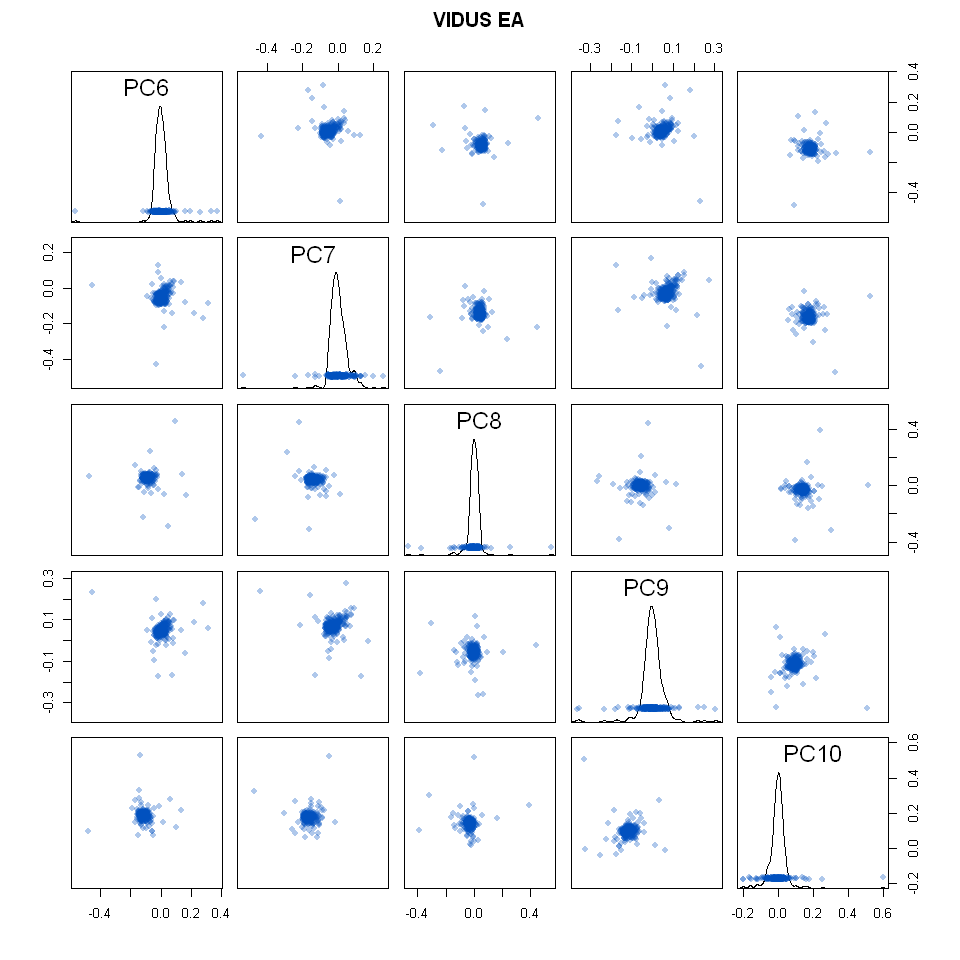

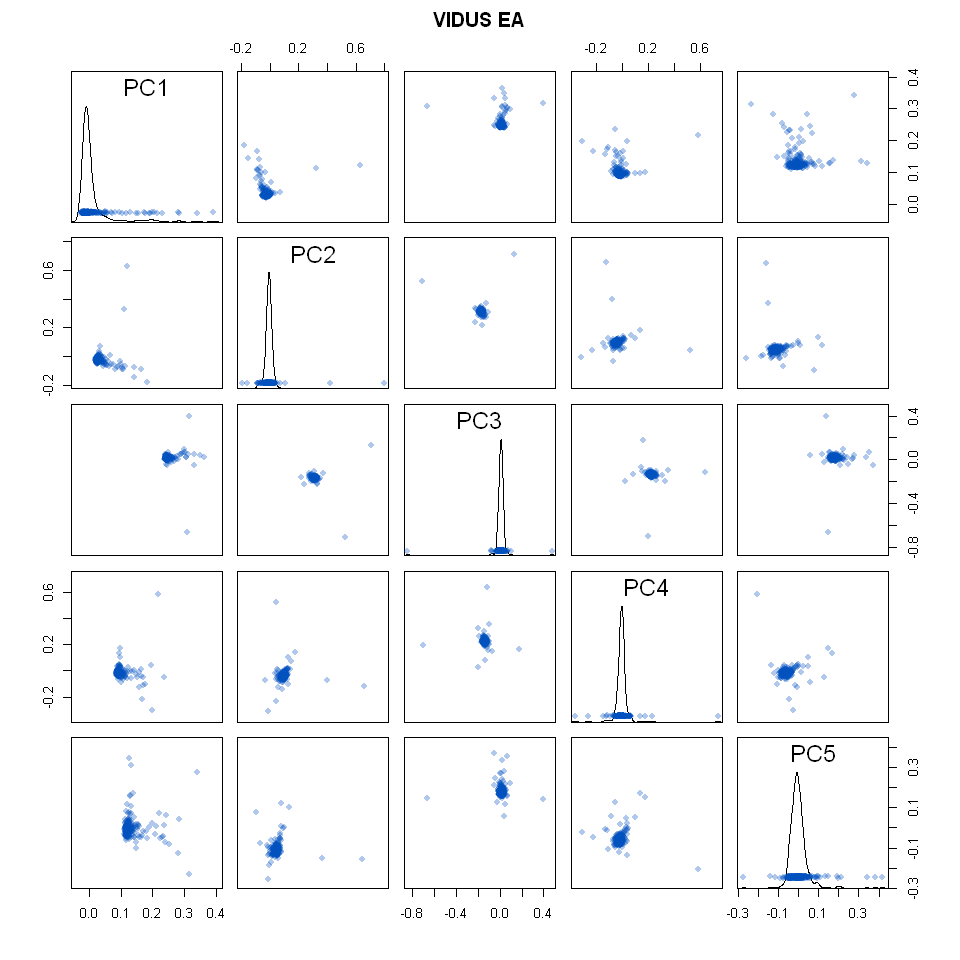

In [34]:
# Function for plotting off-diagonal scatterplots
plot.offdiag <- function(x, y, colors=label.colors){
    #Make x and y axes equal
    limits <- c(min(x,y), max(x,y)) * 1.3
    par(usr = c(limits, limits))
    points(x,y, col=colors, pch=16)
}

# Function for plotting diagonal density plots
plot.diag <- function(x, colors=label.colors){
    d <- density(x, bw=0.01, kernel="gaussian")
    #Update plot axes limits
    par(usr = c(range(d$x), range(d$y)*1.3))
    points(d$x,d$y, type="l")
    #Add PC values
    points(x=x, y=jitter(rep(mean(d$y),times=d$n),factor=5), col=label.colors, pch=16)
}

#Run PCA and get % variance
ea.dspace <- ea.evec[1:10] #transformed dataspace

#Color label samples
label.colors <- rgb(0,80,190,80, maxColorValue=255) #blue

options(repr.plot.width=8, repr.plot.height=8)
#Redefine outer margin
par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,6:10], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",6:10), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="VIDUS EA", cex.main=1)


par(oma = c(4, 1, 2, 1))
pairs(x=ea.dspace[,1:5], panel=plot.offdiag, diag.panel=plot.diag, 
      labels=paste0("PC",1:5), label.pos=0.9, cex.labels=1.8)
par(fig=c(0, 1, 0, 1), oma=c(0, 0, 0, 0), mar=c(0, 0, 1.5, 0), new=TRUE)
plot(0, 0, type = "n", bty = "n", xaxt = "n", yaxt = "n", main="VIDUS EA", cex.main=1)

### Extract eigenvectors

In [ ]:
# Command line # 
cd /shared/sandbox/ngc_vidus-fou/eigenstrat/results

# Grab top 10 eigenvectors from PCA 
ancestry="ea"
# Extract eigenvectors
echo "FID IID EV1 EV2 EV3 EV4 EV5 EV6 EV7 EV8 EV9 EV10" > ${ancestry}_ld_pruned_top10_eigenvecs.txt
tail -n +2 ${ancestry}_ld_pruned.pca.evec | \
    perl -lne 's/:/ /; @F=split; print join(" ",$F[0],$F[1],$F[2],$F[3],$F[4],$F[5],$F[6],$F[7],$F[8],$F[9],$F[10],$F[11]);' \
    >> ${ancestry}_ld_pruned_top10_eigenvecs.txt

## Phenotype processing
### Retrieve covariates and generate mapping file
The covariates we want to include are age (ageatint) and sex (female). Sex is encoded as 0=Male and 1=Female. For the NGC protocol these should be coded as 1 for female and 2 for male.

__Note__: some preprocessing was done do make these conversions easier.

#### Create ped file

In [266]:
# R 

pheno.data <- read.csv("ea_fou_map.data", sep = "\t", header = T, stringsAsFactors = F, 
                       colClasses=c("character", "integer", "integer", "integer"))
#pheno.data
#pheno.data2 <- pheno.data
#pheno.data2[1] <- map.data[1]
#pca.data <- read.csv("ea_ld_pruned_top10_eigenvecs.txt", sep = " " )
#
ped.file <- data.frame(matrix(ncol = 7, nrow = 300))
colnames(ped.file) <- c("fid", "iid", "patid", "matid", "sex", "fou", "age")
ped.file[1] <- pca.data[2]
ped.file[2] <- pca.data[2]
#ped.file
#a <- nchar(ped.file[1,1])
#substr(ped.file[1,1], a-4, a)
#
# map loop (goal to fill in sex and fou on ped.file)
for (i in 1:length(ped.file[,1])){
    a <- nchar(ped.file[i,1])
    key <- substr(ped.file[i,1], a-4, a)
    
    my_match <- match(key, pheno.data[,1])
    ped.file[i,5] <- pheno.data[my_match,2]
    ped.file[i,6] <- pheno.data[my_match,3]
    ped.file[i,7] <- pheno.data[my_match,4]
    
} # end i loop

write.table(ped.file[,1:6], "VIDUS_NGCW1_EUR_phen.ped", sep = "\t", row.names = F, quote=F)
ped.file[,1:6]

fid,iid,patid,matid,sex,fou
8005965489_NA0055919_93-0878,8005965489_NA0055919_93-0878,NA,NA,1,13
8005965444_NA0054104_93-0123,8005965444_NA0054104_93-0123,NA,NA,1,2
8005965456_NA0054107_93-0124,8005965456_NA0054107_93-0124,NA,NA,1,5
8005965468_NA0054106_93-0126,8005965468_NA0054106_93-0126,NA,NA,1,5
8005965480_NA0054090_93-0111,8005965480_NA0054090_93-0111,NA,NA,2,4
8005965445_NA0054401_93-0314,8005965445_NA0054401_93-0314,NA,NA,1,7
8005965505_NA0054235_93-0196,8005965505_NA0054235_93-0196,NA,NA,2,6
8005965517_NA0054230_93-0194,8005965517_NA0054230_93-0194,NA,NA,2,3
8005965529_NA0054238_93-0206,8005965529_NA0054238_93-0206,NA,NA,1,4
8005965470_NA0054981_93-0531,8005965470_NA0054981_93-0531,NA,NA,1,6


#### Create covariate file

In [265]:
covar.data <- data.frame(matrix(ncol = 16, nrow = 300))
colnames(covar.data) <- c("fid", "iid", "patid", "matid", "sex", "age", 
                        "PC1", "PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9","PC10")
covar.data[,1:5] <- ped.file[,1:5]
covar.data[,6] <- ped.file[,7]
#covar.data

pca.data <- read.table("ea_ld_pruned_top10_eigenvecs.txt", header = T)
covar.data[,7:length(covar.data)] <- pca.data[,3:length(pca.data)]
covar.data

write.table(covar.data, "VIDUS_NGCW1_ANCESTRY_cov.ped")

fid,iid,patid,matid,sex,age,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
8005965489_NA0055919_93-0878,8005965489_NA0055919_93-0878,NA,NA,1,54,-0.0137,-0.0248,0.0256,-0.0155,-0.0338,0.0123,0.0751,0.0010,0.0359,0.0203
8005965444_NA0054104_93-0123,8005965444_NA0054104_93-0123,NA,NA,1,57,0.0149,0.0032,0.0179,-0.0415,0.0062,0.0172,0.0426,-0.0254,0.0211,-0.0032
8005965456_NA0054107_93-0124,8005965456_NA0054107_93-0124,NA,NA,1,38,0.2339,0.7885,0.4537,-0.1064,-0.0921,-0.1185,0.0121,0.1191,0.0047,0.0740
8005965468_NA0054106_93-0126,8005965468_NA0054106_93-0126,NA,NA,1,60,-0.0149,0.0173,-0.0017,-0.0017,-0.0228,-0.0284,-0.0271,0.0048,0.0305,0.0301
8005965480_NA0054090_93-0111,8005965480_NA0054090_93-0111,NA,NA,2,52,-0.0329,0.0006,-0.0026,-0.0036,0.0143,-0.0255,-0.0415,-0.0050,-0.0233,-0.0548
8005965445_NA0054401_93-0314,8005965445_NA0054401_93-0314,NA,NA,1,39,-0.0291,0.0026,0.0119,0.0129,0.0121,-0.0112,0.0177,-0.0001,-0.0260,-0.0256
8005965505_NA0054235_93-0196,8005965505_NA0054235_93-0196,NA,NA,2,46,-0.0250,-0.0027,-0.0010,0.0194,-0.0250,-0.0334,-0.0027,-0.0110,-0.0142,0.0077
8005965517_NA0054230_93-0194,8005965517_NA0054230_93-0194,NA,NA,2,33,0.0278,-0.0244,-0.0092,-0.0317,0.0202,0.0051,-0.0329,-0.0035,-0.0141,-0.0200
8005965529_NA0054238_93-0206,8005965529_NA0054238_93-0206,NA,NA,1,53,-0.0249,0.0221,0.0083,0.0180,-0.0139,-0.0194,-0.0487,0.0247,-0.0428,-0.0134
8005965470_NA0054981_93-0531,8005965470_NA0054981_93-0531,NA,NA,1,40,-0.0264,-0.0170,-0.0181,0.0169,-0.0001,-0.0385,-0.0240,0.0023,0.0151,-0.0171


### Descriptive Statistics

In [23]:
# R console #

library(moments)
library(MASS)

# Plot FOU distributions
png("fou_distributions.png", units="in", width=10, height=12, res=200)
par(mfrow=c(3,2))
hist(ea.fou.data$totopioid_tot_30d+1, breaks=30, col="cornflowerblue", border="white", main="EA FOU (30 day total)", xlab="FOU")
hist(aa.fou.data$totopioid_tot_30d+1, breaks=30, col="red3", border="white", main="AA FOU (30 day total)", xlab="FOU")

hist((ea.fou.data$totopioid_tot_30d+1)^ea.lambda, breaks=30, col="cornflowerblue", border="white", main="EA FOU Box-Cox", xlab="Transformed FOU")
hist((aa.fou.data$totopioid_tot_30d+1)^aa.lambda, breaks=30, col="red3", border="white", main="AA FOU Box-Cox", xlab="Transformed FOU")

hist(ea.fou.data$fou, breaks=30, col="cornflowerblue", border="white", main="EA FOU Z-scores", xlab="Z-score", xlim=c(-2.5,3))
hist(aa.fou.data$fou, breaks=30, col="red3", border="white", main="AA FOU Z-scores", xlab="Z-score", xlim=c(-2.5,3))
dev.off()

# Print Box-Cox lambdas
cat("AFR Box-Cox Lambda: ", aa.lambda, "\n")
cat("EUR Box-Cox Lambda: ", ea.lambda, "\n")

# Print categorical variable stats
cat("\n======== sex - AFR ========\n")
rbind(table(aa.fou.data$sex), 
      round(table(aa.fou.data$sex)/sum(table(aa.fou.data$sex))*100, 4))
cat("\n======== sex - EUR ========\n")
rbind(table(ea.fou.data$sex),
      round(table(ea.fou.data$sex)/sum(table(ea.fou.data$sex))*100, 4))

# Print continuous variable stats
for(covar in c("age",paste0("PC",1:10))){
    stats <- summary(ngcw1.afr.cov[,covar])
    cat("======== ", covar, " - AFR ========\n")
    cat("Number of observations: ", length(ngcw1.afr.cov[,covar]), "\n")
    cat("Mean: ", stats[4], "\n")
    cat("Standard Deviation: ", sd(ngcw1.afr.cov[,covar]), "\n")
    cat("Minimum: ", stats[1], "\n")
    cat("Maximum: ", stats[6], "\n")
    cat("Median: ", stats[3], "\n")
    cat("Q1: ", stats[2], "\n")
    cat("Q3: ", stats[5], "\n")
    cat("Skewness: ", skewness(ngcw1.afr.cov[,covar]), "\n")
    cat("Pearson's Kurtosis: ", kurtosis(ngcw1.afr.cov[,covar]), "\n")
    cat("\n")
}
cat("\n\n")
for(covar in c("age",paste0("PC",1:10))){
    stats <- summary(ngcw1.eur.cov[,covar])
    cat("======== ", covar, " - EUR ========\n")
    cat("Number of observations: ", length(ngcw1.eur.cov[,covar]), "\n")
    cat("Mean: ", stats[4], "\n")
    cat("Standard Deviation: ", sd(ngcw1.eur.cov[,covar]), "\n")
    cat("Minimum: ", stats[1], "\n")
    cat("Maximum: ", stats[6], "\n")
    cat("Median: ", stats[3], "\n")
    cat("Q1: ", stats[2], "\n")
    cat("Q3: ", stats[5], "\n")
    cat("Skewness: ", skewness(ngcw1.eur.cov[,covar]), "\n")
    cat("Pearson's Kurtosis: ", kurtosis(ngcw1.eur.cov[,covar]), "\n")
    cat("\n")
}

# Make covariate distribution plots
for(covar in c("age",paste0("PC",1:10))){
    png(paste0(covar, "_distributions.png"), units="in", width=10, height=5, res=200)
    par(mfrow=c(1,2))
    hist(ngcw1.eur.cov[,covar], col="cornflowerblue", border="white", main=paste0("EUR - ", covar," Distribution"), xlab=covar)
    hist(ngcw1.afr.cov[,covar], col="red3", border="white", main=paste0("AFR - ", covar," Distribution"), xlab=covar)
    dev.off()
}

ERROR: Error in library(moments): there is no package called 'moments'


## Run GWAS
### Autosomes

In [ ]:
# Command line # 
mkdir -p /shared/sandbox/ngc_vidus-fou/data/assoc_tests
cd /shared/sandbox/ngc_vidus-fou/data

# Run RVtest
ancestry="ea"
for chr in {1..22}; do
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name ${ancestry}_${chr}_rvtest \
        --script_prefix assoc_tests/${ancestry}_${chr}_rvtest \
        --mem 7.5 \
        --priority 0 \
        --program /shared/bioinformatics/software/third_party/rvtests/executable/rvtest \
            --inVcf genotype/imputed/${ancestry}/chr${chr}/${ancestry}.1000G_p3.chr${chr}.dose.vcf.gz \
            --pheno phenotype/uhs2-3_NGCW1_EUR_phen.ped \
            --pheno-name fou \
            --covar phenotype/uhs2-3_NGCW1_EUR_cov.ped \
            --covar-name sex,age,PC7,PC2,PC8 \
            --xLabel X \
            --meta score \
            --useResidualAsPhenotype \
            --inverseNormal \
            --qtl \
            --dosage DS \
            --out assoc_tests/uhs2-3_EUR_1000G_fou_chr${chr}
done

### ChrX - TODO

## Results processing

### Unfiltered results

In [ ]:
# Command line # 
cd /shared/sandbox/ngc_vidus-fou/data/assoc_tests

# Concatenate chr results together
for ancestry in {AFR,EUR}; do
    echo -e "\n\n ======== ${ancestry} ======== \n\n"
    for chr in {1..22}; do
        zgrep -P "^${chr}\s" uhs2-3_${ancestry}_1000G_fou_chr${chr}.MetaScore.assoc.gz
    done |
        gzip -c > uhs2-3_${ancestry}_1000G_fou.gz
done

# Make results table
for ancestry in {AFR,EUR}; do
    outfile=uhs2-3_${ancestry}_1000G_fou.assoc.table
    echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
    infile=uhs2-3_${ancestry}_1000G_fou.gz
    echo "Processing ${infile}"
    zcat ${infile} | \
        perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                        print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                    } else {
                        print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                    }' >> $outfile
done

# Make Q-Q and manhattan plots
for ancestry in {AFR,EUR}; do
    # Plot all chromosomes
    sh /shared/bioinformatics/software/scripts/qsub_job.sh \
        --job_name gwas_plots_${ancestry} \
        --script_prefix uhs2-3_${ancestry}_1000G_fou.assoc.plot \
        --mem 30.6 \
        --priority 0 \
        --program /shared/bioinformatics/software/R/generate_gwas_plots.R \
            --in uhs2-3_${ancestry}_1000G_fou.assoc.table \
            --in_chromosomes autosomal_nonPAR \
            --in_header \
            --out uhs2-3_${ancestry}_1000G_fou.assoc.plot.all_chr \
            --col_id VARIANT_ID \
            --col_chromosome CHR \
            --col_position POSITION \
            --col_p P \
            --col_variant_type TYPE \
            --generate_snp_indel_manhattan_plot \
            --manhattan_odd_chr_color red3 \
            --manhattan_even_chr_color dodgerblue3 \
            --manhattan_points_cex 1.5 \
            --generate_snp_indel_qq_plot \
            --qq_lines \
            --qq_points_bg black \
            --qq_lambda
done

In [ ]:
# R console #
#install.packages("png", repos="https://mirrors.nics.utk.edu/cran/")
library(png)
png.data <- readPNG("../figures/",native=TRUE)
plot(0:1,0:1,type="n",ann=FALSE,axes=FALSE)
rasterImage(png.data,0,0,1,1)

### MAF > 0.01 and imputation quality > 0.3

In [ ]:
# Command line # 
cd /shared/sandbox/ngc_vidus-fou/data/assoc_tests

# Get list of variants to filter by imputation quality
ancestry="ea"
for chr in {1..22}; do
    echo -e "${ancestry} chr${chr}..."
    zcat ../genotype/imputed/:${ancestry}/chr${chr}/${ancestry}.1000G_p3.chr${chr}.info.gz | \
        tail -n +2 | \
        awk '{ if($5 > 0.01 && $7 > 0.3){ print $1":"$2":"$3 } }' \
        > ${ancestry}_chr${chr}_variants_rsq_gt_0.3.keep
done

# Get list of variants to filter by MAF
ancestry="ea"
if [ $ancestry = aa ]; then
    pop=AFR
else
    pop=EUR
fi
for chr in {1..22}; do
    echo -e "${ancestry} chr${chr}..."
    zgrep -P "^${chr}\s" uhs2-3_${pop}_1000G_fou_chr${chr}.MetaScore.assoc.gz | \
        awk '{ split($6,arr,":"); if(arr[1] > 0.01){ print $1":"$2":"$3":"$4 } }' \
        > ${ancestry}_chr${chr}_variants_maf_gt_0.01.keep
done

# Combine lists
ancestry="ea"
for chr in {1..22}; do
    echo -e "${ancestry} chr${chr}..."
    cat ${ancestry}_chr${chr}_variants_rsq_gt_0.3.keep ${ancestry}_chr${chr}_variants_maf_gt_0.01.keep | \
        sort -u > ${ancestry}_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep
done

# Filter results files
ancestry=EUR
for chr in {1..22}; do
    echo "chr${chr}..."
    awk '{ if(NR==FNR){ map[$1]=1; next } { if(map[$1":"$2":"$3":"$4]==1){ print $0 } } }' \
        ea_chr${chr}_variants_maf_gt_0.01_rsq_gt_0.3.keep \
        <(zgrep -P "^${chr}\s" uhs2-3_${ancestry}_1000G_fou_chr${chr}.MetaScore.assoc.gz) \
        > uhs2-3_${ancestry}_1000G_fou_chr${chr}.tmp
done 
cat uhs2-3_${ancestry}_1000G_fou_chr*tmp | gzip -c > uhs2-3_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.gz

# Clean up
rm *tmp

# Make results table
ancestry="EUR"
outfile=uhs2-3_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.assoc.table
echo -e "VARIANT_ID\tCHR\tPOSITION\tP\tTYPE" > $outfile
infile=uhs2-3_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.gz
echo "Processing ${infile}"
zcat ${infile} | \
    perl -lane 'if (($F[2] eq "A" || $F[2] eq "C" || $F[2] eq "G" || $F[2] eq "T") && (($F[3] eq "A" || $F[3] eq "C" || $F[3] eq "G" || $F[3] eq "T"))) {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"snp");
                } else {
                    print join("\t",$F[0].":".$F[1],$F[0],$F[1],$F[15],"indel");
                }' >> $outfile

# Make Q-Q and manhattan plots
ancestry="EUR"
# Plot all chromosomes
sh /shared/bioinformatics/software/scripts/qsub_job.sh \
    --job_name gwas_plots_${ancestry} \
    --script_prefix uhs2-3_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.assoc.plot \
    --mem 30.6 \
    --priority 0 \
    --program Rscript /shared/bioinformatics/software/R/generate_gwas_plots.R \
        --in uhs2-3_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.assoc.table \
        --in_chromosomes autosomal_nonPAR \
        --in_header \
        --out uhs2-3_${ancestry}_1000G_fou_maf_gt_0.01_rsq_gt_0.3.assoc.plot.all_chr \
        --col_id VARIANT_ID \
        --col_chromosome CHR \
        --col_position POSITION \
        --col_p P \
        --col_variant_type TYPE \
        --generate_snp_indel_manhattan_plot \
        --manhattan_odd_chr_color red3 \
        --manhattan_even_chr_color dodgerblue3 \
        --manhattan_points_cex 1.5 \
        --generate_snp_indel_qq_plot \
        --qq_lines \
        --qq_points_bg black \
        --qq_lambda

## S3 data transfer

In [ ]:
# Command line # 
cd /shared/sandbox/ngc_vidus-fou/genotype/phased

# Copy phasing data
# Compress files
ancestry="ea"
for chr in {1..23}; do
    echo "${ancestry} - chr${chr}"
    gzip ${ancestry}/${ancestry}_chr${chr}_for_phasing.haps
    gzip ${ancestry}/${ancestry}_chr${chr}_for_phasing.sample
done

ancestry="ea"
echo "${ancestry}"
aws s3 cp ${ancestry}/ s3://rti-heroin/ngc_uhs2_uhs3_fou/data/genotype/phased/${ancestry}/ --recursive --exclude "*" --include "*.haps.gz"
aws s3 cp ${ancestry}/ s3://rti-heroin/ngc_uhs2_uhs3_fou/data/genotype/phased/${ancestry}/ --recursive --exclude "*" --include "*.sample.gz"

# Copy imputation data
cd /shared/sandbox/ngc_vidus-fou/genotype/imputed
# Compress files
ancestry="ea"
for chr in {1..23}; do
    echo "${ancestry} - chr${chr}"
    gzip ${ancestry}/chr${chr}/*logfile
    #gzip ${ancestry}/chr${chr}/*info
    #gzip ${ancestry}/chr${chr}/*dose
    #gzip ${ancestry}/chr${chr}/*dose.vcf
done

ancestry="ea"
for chr in {1..23}; do
    echo "${ancestry} - chr${chr}"
    aws s3 cp ${ancestry}/chr${chr}/ s3://rti-heroin/ngc_uhs2_uhs3_fou/data/genotype/imputed/${ancestry}/ --recursive --exclude "*" --include "*.info.gz"
    aws s3 cp ${ancestry}/chr${chr}/ s3://rti-heroin/ngc_uhs2_uhs3_fou/data/genotype/imputed/${ancestry}/ --recursive --exclude "*" --include "*.logfile.gz"
    aws s3 cp ${ancestry}/chr${chr}/ s3://rti-heroin/ngc_uhs2_uhs3_fou/data/genotype/imputed/${ancestry}/ --recursive --exclude "*" --include "*dose.gz"
    aws s3 cp ${ancestry}/chr${chr}/ s3://rti-heroin/ngc_uhs2_uhs3_fou/data/genotype/imputed/${ancestry}/ --recursive --exclude "*" --include "*dose.vcf.gz"
done

# Copy association test results
cd /shared/sandbox/ngc_uhs2_uhs3_fou/data/assoc_tests/
# Compress files
gzip *.png
aws s3 cp ./ s3://rti-heroin/ngc_uhs2_uhs3_fou/results/rvtest/ --recursive --exclude="*" --include="*MetaScore*gz*"
aws s3 cp ./ s3://rti-heroin/ngc_uhs2_uhs3_fou/results/figures/ --recursive --exclude="*" --include="*.png.gz"

# Copy phenotype data
cd /shared/s3/ngc_uhs2_uhs3_fou/data/phenotype/
# Compress files
gzip *.ped
aws s3 cp ./ s3://rti-heroin/ngc_uhs2_uhs3_fou/data/phenotype --recursive --exclude="*" --include="*ped.gz"